Install Needed Packages


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
from pathlib import Path
from tqdm import tqdm
import pickle

In [2]:
import torch.nn.functional as F

In [3]:
#import tqdm.notebook as tqdm


In [3]:
import torch.nn as nn
import numpy as np

In [3]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:0")
    print("Is cuDNN version:", torch.backends.cudnn.version())
    print("cuDNN enabled:a", torch.backends.cudnn.enabled)
    print("Device count: ", torch.cuda.device_count())
    print("Current device: ", torch.cuda.current_device())
    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Cuda available:  True
Is cuDNN version: 8700
cuDNN enabled:a True
Device count:  3
Current device:  0
Device name:  NVIDIA RTX A6000
cuda


Process the Data + Create a Dataloader

In [8]:

transformResizer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Convert images to tensor
])
dataset = datasets.ImageFolder(root='data', transform = transformResizer)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

train_dataset = []
val_dataset = []


for sample in dataloader:
    x, y = sample
    x = x[0]
    if len(val_dataset) <= int(0.12 * len(dataset)):
        val_dataset.append((x, y[0]))
    else:
        train_dataset.append((x, y[0]))



In [6]:
#net
# Basic Block for ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(16384, 2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Create ResNet18 model
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Instantiate the ResNet18 model
net = ResNet18().to(device)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# %%
epochs = 40
learning_rate = 0.00001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)

net.train()  # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    for x, y in tqdm(train_dataloader):
        x, y = x.float().to(device), y.type(torch.LongTensor).to(device)  # Change y to LongTensor
        optimizer.zero_grad()  # Remove the gradients from the previous step
        pred = net(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    net.train()
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))
    #train_loss_arr.append(np.mean(training_losses))
    # determine train and validation accuracies
    with torch.no_grad():
      net.eval()  # Put model in eval mode
      num_correct_train = 0
      for x, y in train_dataloader:
          x, y = x.float().to(device), y.long().to(device)  # Change y to LongTensor
          pred = net(x)
          num_correct_train += torch.sum(torch.argmax(pred, dim=1) == y).item()  # Compare with argmax
      train_acc = num_correct_train / len(train_dataset)
      #train_acc_arr.append(train_acc)
      print("Train Accuracy:", train_acc)
      num_correct_val = 0
      for x, y in val_dataloader:
          x, y = x.float().to(device), y.long().to(device)  # Change y to LongTensor
          pred = net(x)
          num_correct_val += torch.sum(torch.argmax(pred, dim=1) == y).item()  # Compare with argmax
      val_acc = num_correct_val / len(val_dataset)
      #val_acc_arr.append(val_acc)
      print("Val Accuracy:", val_acc)
    net.train()  # Put model back in train mode



  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:01<00:00, 13.89it/s]


Finished Epoch 1 , training loss: 0.14910088364894575
Train Accuracy: 0.9827586206896551
Val Accuracy: 0.972972972972973


100%|██████████| 26/26 [00:01<00:00, 13.89it/s]


Finished Epoch 2 , training loss: 0.11353055760264397
Train Accuracy: 0.9864532019704434
Val Accuracy: 0.972972972972973


100%|██████████| 26/26 [00:01<00:00, 13.86it/s]


Finished Epoch 3 , training loss: 0.09752635571819085
Train Accuracy: 0.9852216748768473
Val Accuracy: 0.972972972972973


100%|██████████| 26/26 [00:01<00:00, 13.86it/s]


Finished Epoch 4 , training loss: 0.0906656663864851
Train Accuracy: 0.9864532019704434
Val Accuracy: 0.972972972972973


100%|██████████| 26/26 [00:01<00:00, 13.85it/s]


Finished Epoch 5 , training loss: 0.08810011512384965
Train Accuracy: 0.9864532019704434
Val Accuracy: 0.963963963963964


100%|██████████| 26/26 [00:01<00:00, 13.82it/s]


Finished Epoch 6 , training loss: 0.07907611145996131


KeyboardInterrupt: 

In [13]:
torch.save(net.state_dict(), "best_checkpoint_dict.pth")

In [ ]:
# save the reef classification model as a pickle file
model_pkl_file = "reef_classification_model.pkl"
with open(model_pkl_file, 'wb') as file:
    pickle.dump(net, file)

In [39]:
with torch.no_grad():
      net.eval()  # Put model in eval mode
      num_correct_train = 0
      for x, y in train_dataloader:
          x, y = x.float().to(device), y.long().to(device)  # Change y to LongTensor
          pred = net(x)
          num_correct_train += torch.sum(torch.argmax(pred, dim=1) == y).item()  # Compare with argmax
      train_acc = num_correct_train / len(train_dataset)
      #train_acc_arr.append(train_acc)
      print("Train Accuracy:", train_acc)
      num_correct_val = 0
      for x, y in val_dataloader:
          x, y = x.float().to(device), y.long().to(device)  # Change y to LongTensor
          pred = net(x)
          for i in range(len(x)):
            pred_sig = torch.nn.functional.softmax(pred[i], dim=0)
            print("Label Confidence: " + str(torch.max(pred_sig).item()))
          num_correct_val += torch.sum(torch.argmax(pred, dim=1) == y).item()  # Compare with argmax
      val_acc = num_correct_val / len(val_dataset)
      #val_acc_arr.append(val_acc)
      print("Val Accuracy:", val_acc)

Train Accuracy: 0.9876847290640394
Label Confidence: 0.9839044809341431
Label Confidence: 0.7145802974700928
Label Confidence: 0.9967398047447205
Label Confidence: 0.9942498207092285
Label Confidence: 0.7813279032707214
Label Confidence: 0.9811136722564697
Label Confidence: 0.9631255865097046
Label Confidence: 0.975009024143219
Label Confidence: 0.9382098317146301
Label Confidence: 0.9991776347160339
Label Confidence: 0.6887455582618713
Label Confidence: 0.9753236770629883
Label Confidence: 0.7499551773071289
Label Confidence: 0.9550952315330505
Label Confidence: 0.598309338092804
Label Confidence: 0.8542718887329102
Label Confidence: 0.9223062992095947
Label Confidence: 0.8898025155067444
Label Confidence: 0.7979152798652649
Label Confidence: 0.9993720650672913
Label Confidence: 0.9029510021209717
Label Confidence: 0.9476364850997925
Label Confidence: 0.972488284111023
Label Confidence: 0.8034029603004456
Label Confidence: 0.995376467704773
Label Confidence: 0.9948601722717285
Label C

In [90]:

# forward pass demo - "blackbox"
label_dict = {}
label_dict[0] = "Bleached"
label_dict[1] = "Normal"

ground_truth_dataset = datasets.ImageFolder(root='data', transform = None)

i = 0
pil_img = ground_truth_dataset[i][0]
y = ground_truth_dataset[i][1]

def predict(pil_img, y = 0):
    img1 = torchvision.transforms.functional.pil_to_tensor(pil_img)
    img_rgb = torch.stack((img1[0], img1[1], img1[2]), dim=2)
    plt.imshow(img_rgb.numpy())
    plt.axis(False)
    trans_img = transformResizer(pil_img).to(device).unsqueeze(dim=0)
    pred_img = net(trans_img)
    pred_sig = torch.nn.functional.softmax(pred_img, dim=1)
    confidence = round(torch.max(pred_sig).item(), 5)
    print("Label Confidence: " + str(confidence))
    pred_label = torch.argmax(pred_img).item()
    print("Prediction: " + str(pred_label))
    #print("Ground Truth: " + str(y))
    plt.title("Prediction: " + label_dict[pred_label]  + "\n Confidence: " + str(confidence), loc = 'center')
    return(pred_label, confidence)

SyntaxError: invalid syntax (3660326285.py, line 8)

<class 'PIL.Image.Image'>
Label Confidence: 0.95911
Prediction: 0


(0, 0.95911)

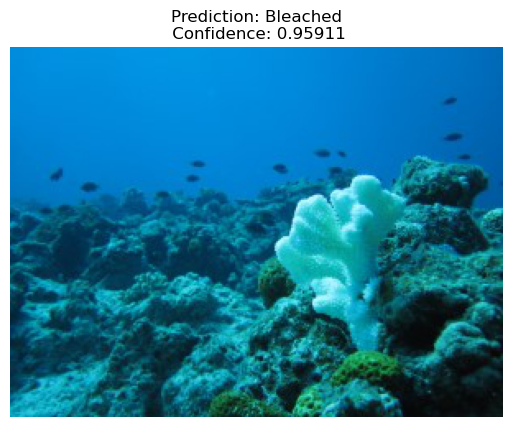

In [91]:
print(type(pil_img))
predict(pil_img)

In [88]:
# Specify a path
PATH = "entire_model.pt"

# Save
torch.save(net, PATH)

# Load
model = torch.load(PATH)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
### REMOTE MODEL

In [92]:
remote_net = torch.load("entire_model.pt")
remote_net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [94]:
def predict_fn(pil_img, y = 0):
    img1 = torchvision.transforms.functional.pil_to_tensor(pil_img)
    img_rgb = torch.stack((img1[0], img1[1], img1[2]), dim=2)
    plt.imshow(img_rgb.numpy())
    plt.axis(False)
    trans_img = transformResizer(pil_img).to(device).unsqueeze(dim=0)
    pred_img = net(trans_img)
    pred_sig = torch.nn.functional.softmax(pred_img, dim=1)
    confidence = round(torch.max(pred_sig).item(), 5)
    print("Label Confidence: " + str(confidence))
    pred_label = torch.argmax(pred_img).item()
    print("Prediction: " + str(pred_label))
    #print("Ground Truth: " + str(y))
    plt.title("Prediction: " + label_dict[pred_label]  + "\n Confidence: " + str(confidence), loc = 'center')
    return(pred_label, confidence)

Label Confidence: 0.97786
Prediction: 0


(0, 0.97786)

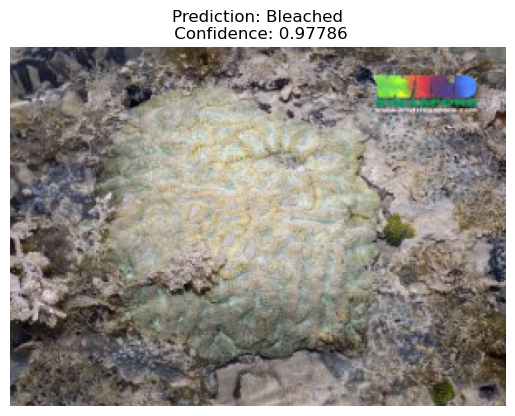

In [95]:
# forward pass demo - "blackbox"
label_dict = {}
label_dict[0] = "Bleached"
label_dict[1] = "Normal"

ground_truth_dataset = datasets.ImageFolder(root='data', transform = None)

i = 0
pil_img = ground_truth_dataset[i][0]
y = ground_truth_dataset[i][1]

predict_fn(pil_img)